In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #disable tensorflow warnings

In [3]:

def read_from_source():
    df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
    df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
    df['Date'] = pd.to_datetime(df['Date'])
    return df



def pred_covid(model_name, df, model_idx): #GRU or LSTM
    #model = load_model('../'+model_name +'_infected_only_GRU_LSTM_Oct16.h5') #best
    model = load_model('LSTM_GRU_Oct23_relu/' + model_name +'_infected_only_Oct23_'+str(model_idx)+'.h5')
    print(model_name,'loaded')

    #constant
    n_steps_in = 14
    n_steps_out = 4
    sc = MinMaxScaler(feature_range = (0, 1))
    
    x_input = df['Infected'][-n_steps_in:].values # last 14 day
    x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
    x_input = x_input.reshape((1, n_steps_in, 1))
    
    #y_pred = model.predict(x_input) # too much warnings
    y_pred = model(x_input)
    y_pred = sc.inverse_transform(y_pred) #revert scaling
    #print('Next 4 days prediction:', y_pred)
    
    start_date = str(df['Date'].iloc[-14])[:10]
    end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
    end_date = str(end_date)[:10]
    #print(start_date,'---', end_date)
    time_range = pd.date_range(start=start_date, end=end_date)
    
    pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred[0,:]))
    return pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

In [4]:
df = read_from_source()
df

,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0
...,...,...
642,2021-10-19,367.0
643,2021-10-20,387.0
644,2021-10-21,334.0
645,2021-10-22,324.0


In [5]:
df[-14:]

,Date,Infected
633,2021-10-10,546.0
634,2021-10-11,359.0
635,2021-10-12,609.0
636,2021-10-13,723.0
637,2021-10-14,612.0
638,2021-10-15,522.0
639,2021-10-16,502.0
640,2021-10-17,425.0
641,2021-10-18,223.0
642,2021-10-19,367.0


In [6]:
pred_covid('GRU', df,3)

GRU loaded


,Date,Predict Infected
0,2021-10-24,262.926272
1,2021-10-25,323.859627
2,2021-10-26,297.105896
3,2021-10-27,223.000000


In [7]:
def get_prediction(model, df): #model = 'GRU' or 'LSTM'
    pred_arr = []
    for model_idx in [1,2,3]:
        #print(model,model_idx,pred_covid(model, df,model_idx))
        pred_arr.append(np.array(pred_covid(model, df,model_idx)['Predict Infected'].values))
    return np.array(pred_arr)

In [8]:
def get_PI(pred_arr):
    intervals = []
    means = []
    uppers = []
    lowers = []
    for idx in [0,1,2,3]:
        cov_std = pred_arr[:,idx].std()
        cov_interval = cov_std*1.96
        cov_mean = pred_arr[:,idx].mean()
        cov_lower = cov_mean - cov_interval
        cov_upper = cov_mean + cov_interval
        print(pred_arr[:,idx], 'Interval: ',cov_interval , 'Upper: ',cov_lower, 'Mean: ',cov_mean, 'Upper: ',cov_upper)
        
        intervals.append(int(cov_interval))
        means.append(int(cov_mean))
        uppers.append(int(cov_upper))
        lowers.append(int(cov_lower))
    
    return intervals, means, uppers, lowers

In [9]:
%%time
GRU_pred_arr = get_prediction('GRU',df)
cov_intervals, cov_means, cov_uppers, cov_lowers = get_PI(GRU_pred_arr)


GRU loaded
GRU loaded
GRU loaded
[285.23337352 245.33951166 262.92627189] Interval:  31.996136265633332 Upper:  232.5035827580712 Mean:  264.49971902370453 Upper:  296.49585528933784
[285.3446703  269.66293412 323.85962713] Interval:  44.63084588756888 Upper:  248.32489796170856 Mean:  292.95574384927744 Upper:  337.58658973684635
[333.25903374 296.36145639 297.10589606] Interval:  33.752965248590655 Upper:  275.15583014789615 Mean:  308.9087953964868 Upper:  342.6617606450775
[314.94052219 293.02203912 223.        ] Interval:  76.85090179614319 Upper:  200.13661864030263 Mean:  276.98752043644583 Upper:  353.83842223258904
Wall time: 3.82 s


In [10]:
GRU_pred_arr

array([[285.23337352, 285.3446703 , 333.25903374, 314.94052219],
       [245.33951166, 269.66293412, 296.36145639, 293.02203912],
       [262.92627189, 323.85962713, 297.10589606, 223.        ]])

In [11]:
cov_means

[264, 292, 308, 276]

In [12]:
y = cov_means


In [31]:
time_range = pd.date_range(start='2021-10-10', end='2021-10-27')


In [32]:
time_range[:-4]

DatetimeIndex(['2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17',
               '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-23'],
              dtype='datetime64[ns]', freq='D')

In [33]:
df['Infected'][-14:]

633    546.0
634    359.0
635    609.0
636    723.0
637    612.0
638    522.0
639    502.0
640    425.0
641    223.0
642    367.0
643    387.0
644    334.0
645    324.0
646    277.0
Name: Infected, dtype: float64

In [34]:
cov_intervals

[31, 44, 33, 76]

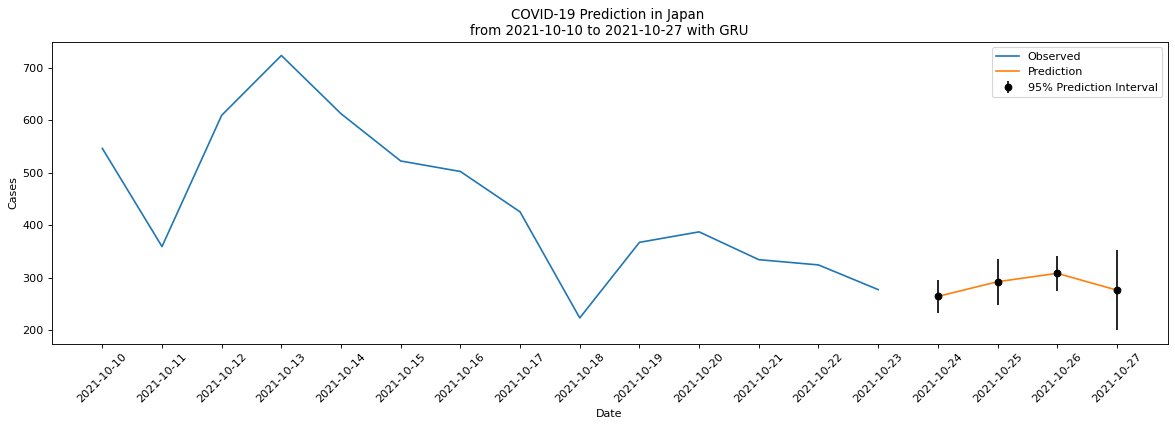

In [35]:
from matplotlib.pyplot import figure
figure(figsize=(18, 5), dpi=80)

plt.plot(time_range[:-4],df['Infected'][-14:], label='Observed')
plt.plot(time_range[-4:],y, label='Prediction')

plt.errorbar(time_range[-4], y[0], yerr=cov_intervals[0] , color='black', fmt='o', label='95% Prediction Interval')
plt.errorbar(time_range[-3], y[1], yerr=cov_intervals[1] , color='black', fmt='o')
plt.errorbar(time_range[-2], y[2], yerr=cov_intervals[2], color='black', fmt='o')
plt.errorbar(time_range[-1], y[3], yerr=cov_intervals[3], color='black', fmt='o')

plt.xlabel('Date')
plt.ylabel('Cases')
plt.xticks(time_range,rotation=45)
plt.title('COVID-19 Prediction in Japan \nfrom 2021-10-10 to 2021-10-27 with GRU')
plt.legend()
plt.show()

### Read data from source

In [18]:
df = pd.read_csv('https://toyokeizai.net/sp/visual/tko/covid19/csv/pcr_positive_daily.csv')
df = df.rename(columns={'日付': 'Date', 'PCR 検査陽性者数(単日)': 'Infected'}) #renaming from Japanese to English
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)
print(df.shape)
df.tail()

Date        datetime64[ns]
Infected           float64
dtype: object
(647, 2)


,Date,Infected
642,2021-10-19,367.0
643,2021-10-20,387.0
644,2021-10-21,334.0
645,2021-10-22,324.0
646,2021-10-23,277.0


### Load GRU

In [19]:
model_GRU = load_model('../GRU_infected_only_GRU_LSTM_Oct16.h5')
model_GRU

In [20]:
n_steps_in = 14
n_steps_out = 4

In [21]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))

In [22]:
x_input = df['Infected'][-n_steps_in:].values # last 14 day
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [23]:
y_pred_GRU = model_GRU.predict(x_input)
y_pred_GRU = sc.inverse_transform(y_pred_GRU) #revert scaling
print(y_pred_GRU)

[[231.76816 193.36447 161.47987 161.77902]]


In [24]:
x_input_raw = df['Infected'][-n_steps_in:].values
print(x_input_raw.reshape(n_steps_in))

[546. 359. 609. 723. 612. 522. 502. 425. 223. 367. 387. 334. 324. 277.]


### Range: 18 days

In [25]:
start_date = str(df['Date'].iloc[-14])[:10]

end_date = df['Date'].iloc[-15] + pd.Timedelta(18, unit='D')                  
end_date = str(end_date)[:10]

print(start_date,'---', end_date)

2021-10-10 --- 2021-10-27


In [26]:
time_range = pd.date_range(start=start_date, end=end_date)
print(time_range.shape)

(18,)


In [27]:
y_pred_GRU[0,:]

array([231.76816, 193.36447, 161.47987, 161.77902], dtype=float32)

In [28]:
pred_list = list(zip(time_range[-4:].strftime('%Y-%m-%d'), y_pred_GRU[0,:]))
pred_list

[('2021-10-24', 231.76816),
 ('2021-10-25', 193.36447),
 ('2021-10-26', 161.47987),
 ('2021-10-27', 161.77902)]

In [29]:
pd.DataFrame (pred_list, columns = ['Date', 'Predict Infected'])

,Date,Predict Infected
0,2021-10-24,231.768158
1,2021-10-25,193.364471
2,2021-10-26,161.479874
3,2021-10-27,161.779022


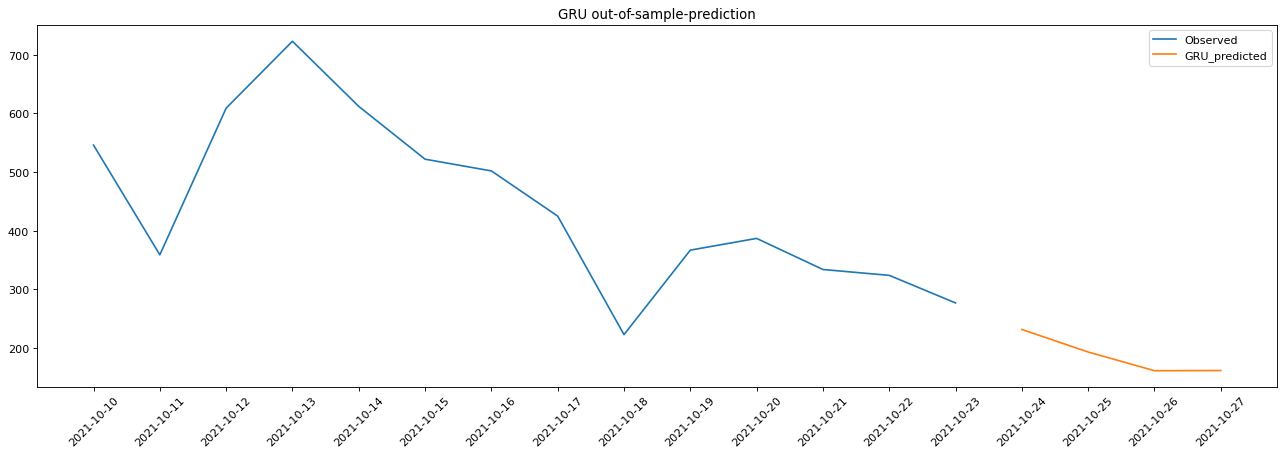

In [30]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.plot(time_range[:14],x_input_raw.reshape(n_steps_in), label='Observed')
plt.plot(time_range[14:], y_pred_GRU[0,:], label='GRU_predicted')
plt.title('GRU out-of-sample-prediction')
plt.xticks(time_range,rotation=45)
plt.legend()
plt.show()